In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys

In [2]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(salt=13, U0=0.0,
                W=200, L=200, mu=0.6, mu_lead=0.6, phi=0):

    
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < L) and (0 <= y < W)
        
    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        return -t*exp(-1j * pi* phi * (xi - xj) * (yi + yj-W))
    
    def onsite(site, mu, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu)


    lat = kwant.lattice.honeycomb(norbs=1)
    subA, subB = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (0,0))] = onsite
    syst[(subB(x,-1) for x in range(L))] = onsite
    syst[lat.neighbors()] = hopping_ab
    
#     def lead_slab(pos):
#         (x, y) = pos 
#         return (0<= x < 1) and (0 <= y < W)
    
    sym_left = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    left_lead = kwant.Builder(sym_left)
#     left_lead[lat.shape(lead_slab, (0,0))] = onsite
    L_lead=int(W/(sqrt(3)/2))
    left_lead[(subA(0,y) for y in range(L_lead+1))] = onsite
    left_lead[(subB(0,y) for y in range(-1,L_lead))] = onsite
    left_lead[lat.neighbors()] = hopping_ab
    syst.attach_lead(left_lead)
    syst.attach_lead(left_lead.reversed())

#     a0=3/(4*sqrt(3))
#     b0=0.5
#     primitive_vectors = [(b0, 0), (0, a0)]
#     lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(0, a0/6),norbs=4)
    
            
#     # leads
#     def onsite_lead(site, mu_lead):
#         return  (- mu_lead + 4 * t)* np.kron(tau_z,np.eye(2))

#     def hopping_lead(site1, site2):
#         return -t*np.kron(tau_z,np.eye(2))

#     # Manually attach sites from graphene to square lattice
#     Wsys=int(W/a0)
#     Lsys=int(L/b0)
#     syst[(lat_sc(-1, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(-1, i), lat_sc(-1, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(-1, 2*i), subA(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(-1, 2*i+1), subB(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[(lat_sc(Lsys, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(Lsys, i), lat_sc(Lsys, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i), subA(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i+1), subB(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead

#     claw=-np.kron(np.eye(2),tau_z)
#     sym_left = kwant.TranslationalSymmetry(lat_sc.vec((-1, 0)))
#     left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
#     left_lead[(lat_sc(0,y) for y in range(Wsys))] = onsite_lead
#     left_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_ab
#     left_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_ab
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

    
    return syst

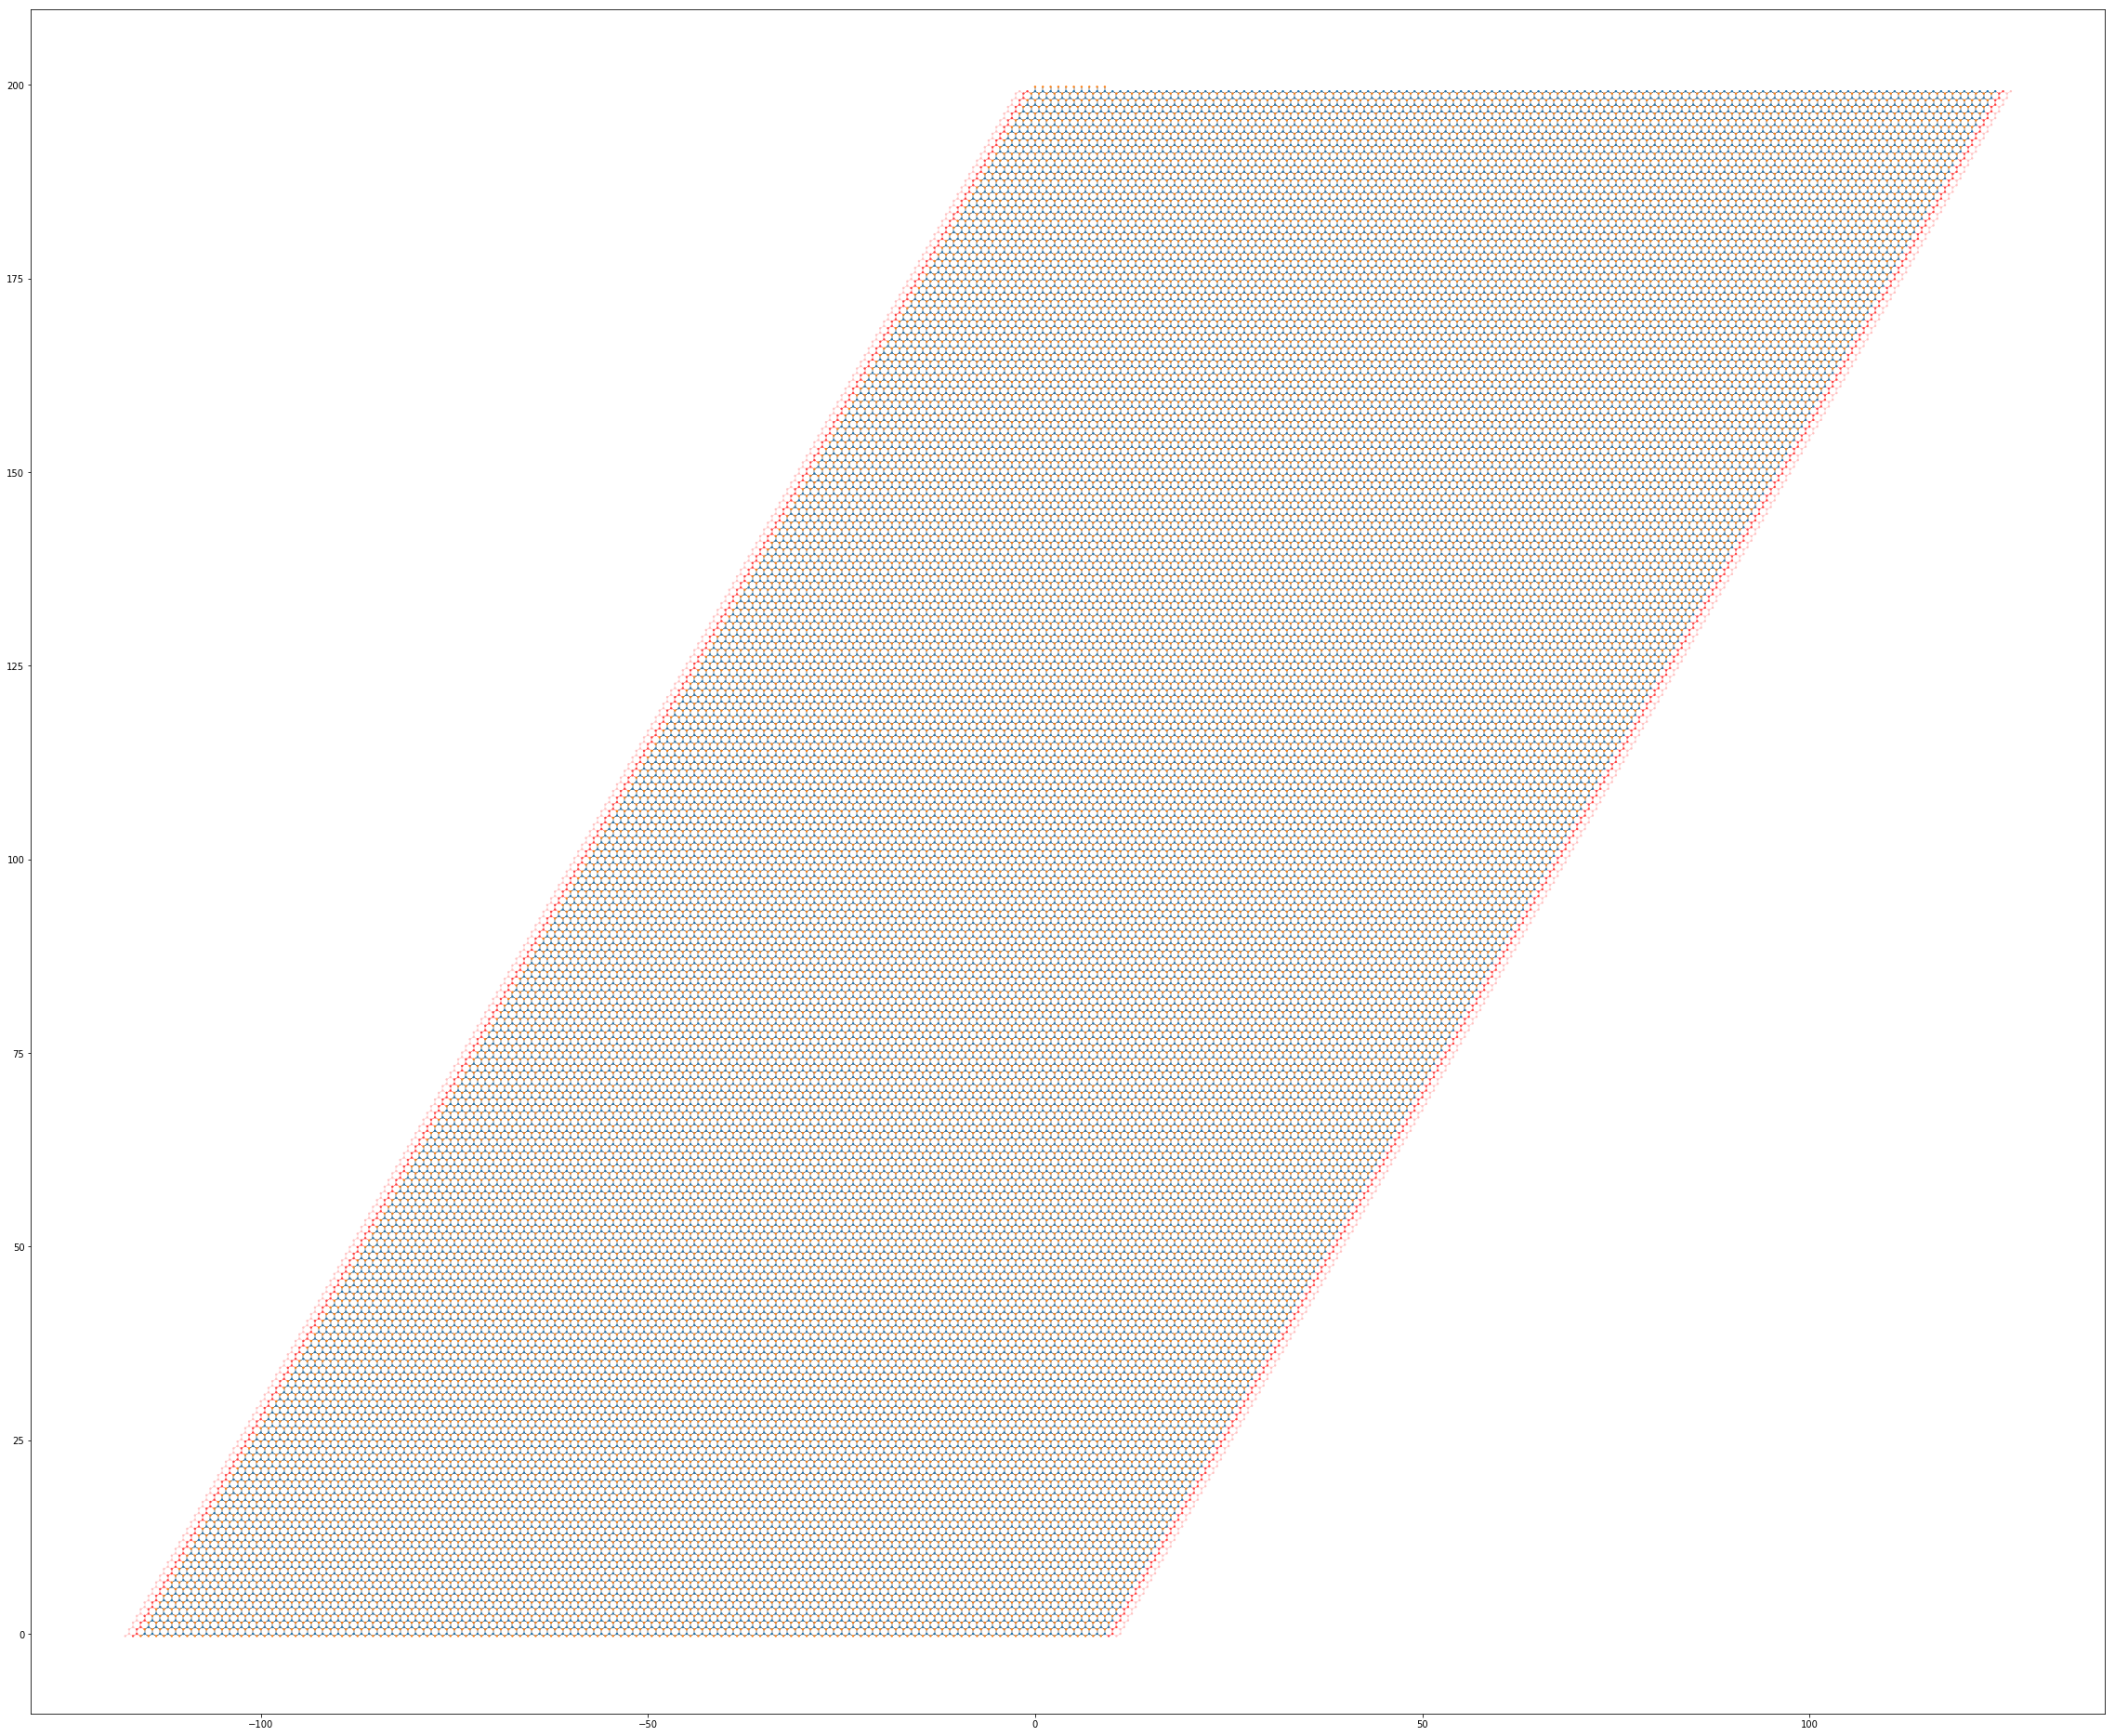

In [8]:
# Wsc must be multiples of eight
W=200
L=10
syst = make_system(W=W, L=L)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,80))
# kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: The plotted data contains 1.82% of values overflowing upper limit 0.0847156 
  # This is added back by InteractiveShellApp.init_path()


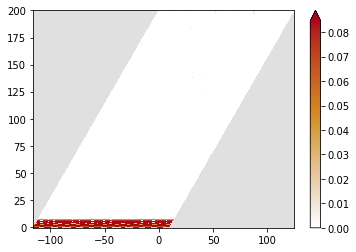

(1, 57760)


In [9]:
mu_lead=2
mu=0.1
phi=0.02
U0=0.0 # disorder strength
salt=13

energy=0
params=dict(mu_lead=mu_lead ,mu=mu, phi=phi, U0=U0, salt=salt)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,:])**2, axis=0));
print(scattering_wf.shape)
ind=0

In [10]:
mu_lead=0.6
mu=0.0
U0=0.0 # disorder strength
salt=13
momenta = [-pi + 0.02 * pi * i for i in range(101)]
def plot_wf(phi=0):
    params=dict(mu_lead=mu_lead ,mu=mu, phi=phi,U0=U0,salt=salt,momenta=momenta)
    fig = plt.figure()  # create a figure object
    ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
    ax1.set_ylim(-0.1,0.5)
    plt.title(r'$\phi=$ %.3f' % (phi))
    plt.show()
    
interact(plot_wf, phi=(0, 0.01, 0.001));

interactive(children=(FloatSlider(value=0.0, description='phi', max=0.01, step=0.001), Output()), _dom_classes…

In [11]:
# armchair edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(W=200, L=200, mu=0.6, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < L) and (0 <= y < W)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        return -t*exp(-1j * pi* phi * (xi - xj) * (yi + yj-W))

    def onsite(site, mu):
        return  - mu

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 1/2),(5/sqrt(3)/2, 1/2)],norbs=1)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (0,0))] = onsite
    syst[lat.neighbors()] = hopping_ab


    sym_right = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    right_lead = kwant.Builder(sym_right)
    right_lead[lat.shape(qh_slab, (0,0))] = onsite
    right_lead[lat.neighbors()] = hopping_ab
    
    syst.attach_lead(right_lead)
    syst.attach_lead(right_lead.reversed())

    
    return syst

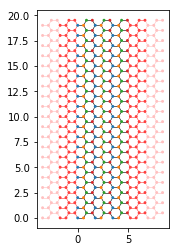

In [22]:
# Wsc must be multiples of eight
W=20
L=4
syst = make_system(W=W, L=L)
# Check that the system looks as intended.
# kwant.plot(syst, colorbar=False,fig_size=(40,80),num_lead_cells=2)
kwant.plot(syst,num_lead_cells=2)
# Finalize the system.
syst = syst.finalized()

In [23]:
mu=0.0
momenta = [-pi + 0.02 * pi * i for i in range(101)]
def plot_wf(phi=0):
    params=dict(mu=mu, phi=phi, momenta=momenta)
    fig = plt.figure()  # create a figure object
    ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
    ax1.set_ylim(-0.1,1)
    plt.title(r'$\phi=$ %.3f' % (phi))
    plt.show()
    
interact(plot_wf, phi=(0, 0.01, 0.001));

interactive(children=(FloatSlider(value=0.0, description='phi', max=0.01, step=0.001), Output()), _dom_classes…

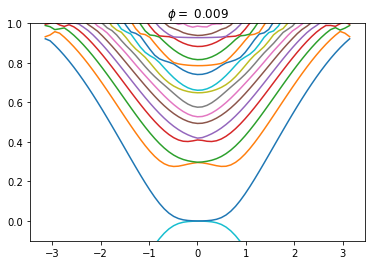

In [24]:
plot_wf(phi=0.0095)